Working on a caller using DBScan. This version is a targeted one, an untargeted version that goes through the whole genome also exists.

In [1]:
# Import modules
#pip install opencv-python
import sys
import os
import numpy as np
import math
import matplotlib
#matplotlib.use('Agg')
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import scipy.signal
import pandas as pd
import pyranges
import itertools
import csv
from joblib import Parallel, delayed
import cv2
from scipy import ndimage
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import DBSCAN 
%matplotlib inline

In [2]:
# Define auxiliary functions
def HM_bins(dataframe,name_png,cmap_col = "Oranges",size = [24,30]):
    fig, ax = plt.subplots()
    im = ax.imshow(dataframe,cmap=cmap_col,vmin=0, vmax=max(dataframe.values.max(),0.1))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(dataframe.columns)))
    ax.set_yticks(np.arange(len(dataframe.index)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(dataframe.columns)
    ax.set_yticklabels(dataframe.index)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)
    
    ax.set_title(name_png)
    plt.xlabel(dataframe.columns[1].split(':')[0])
    plt.ylabel(dataframe.index[1].split(':')[0])

    fig.tight_layout()
    #plt.show()
    
    figure = plt.gcf()
    figure.set_size_inches(size[0], size[1])
    plt.savefig(name_png +".png",dpi=100)
    #plt.savefig(name_png +".eps",dpi=100)
    plt.show()
    plt.close()

def make_bins(chrom_size,bin_size):
    for index, i in chrom_size.iterrows():
        if 'dfbins' in locals():
            dfbins= pd.concat([dfbins,pd.DataFrame({"Chromosome":i[0],"Start":(np.arange(0,i[1],bin_size)+1),\
                                                    "End":np.arange(0,(i[1]+bin_size),bin_size)[1:] })])
        else:
            dfbins=pd.DataFrame({"Chromosome":i[0],"Start":(np.arange(0,i[1],bin_size)+1),\
                                 "End":np.arange(0,(i[1]+bin_size),bin_size)[1:] })
    dfbins["Bin"]=dfbins.Chromosome+":"+dfbins.Start.map(str)+"-"+dfbins.End.map(str)
    return dfbins

def filtering_bins(dfbins,region1,region2,bin_size):
    region1=region1.replace(',', '')
    region2=region2.replace(',', '')
    region1_chr=region1.split(':')[0]
    region2_chr=region2.split(':')[0]
    region1_start=int(region1.split(':')[1].split('-')[0])-bin_size
    region2_start=int(region2.split(':')[1].split('-')[0])-bin_size
    region1_end=int(region1.split(':')[1].split('-')[1])+bin_size
    region2_end=int(region2.split(':')[1].split('-')[1])+bin_size
    dfbins1=dfbins[dfbins.Chromosome==region1_chr]
    #dfbins1=dfbins1[(dfbins1.columns.str.startswith('Start')>=region1_start) & (dfbins1.columns.str.startswith('End')<=region1_end)]
    #df.loc[:, dfbins1.columns.str.startswith('Start')]
    
    dfbins1=dfbins1[(dfbins1.Start>=region1_start) & (dfbins1.End<=region1_end)]
    dfbins2=dfbins[dfbins.Chromosome==region2_chr]
    dfbins2=dfbins2[(dfbins2.Start>=region2_start) & (dfbins2.End<=region2_end)]
    dfbins_fin=pd.concat([dfbins1,dfbins2])
    return dfbins_fin

In [3]:
# Reading data
bin_size=100000
patient="P11603_125"
path="/Users/lucia.pena.perez/OneDrive - KI.SE/MANUSCRIPTS 10x lrWGS genetics/Data/lrwgs_barcrawler/barcrawler-results-"
file_name="/phased_possorted_bam_MoleculeSpan.tab"
path_hg38_size="/Users/lucia.pena.perez/OneDrive - KI.SE/temp foxo/MM/Hg38-chromosome-size.txt"
chromosomes=["chr"+ str(int(x)) for x in np.linspace(1,22,num=22)]
df_all=pd.read_csv(path+patient+file_name, sep='\t', engine='python')

# Filter unwanted chromosomes
df_all=df_all.loc[df_all['#chromosome'].isin(chromosomes)]
# Filtering those with less than 10 reads and shorter than 1kb
df_all=df_all[df_all.n_reads>=10]
df_all=df_all[(df_all.end-df_all.start)>=10000]
df_all=df_all[["#chromosome","start","start","BX"]]
df_all.columns=["Chromosome","Start","End","BX"]

if not os.path.exists(path+patient+"/chr-heatmaps/"):
    os.mkdir(path+patient+"/chr-heatmaps/")

# Making bins
chrom_size=pd.read_csv(path_hg38_size, sep='\t', engine='python',names=["chr_name","chr_len"])
dfbins=make_bins(chrom_size,bin_size)
dfbins=dfbins.loc[dfbins['Chromosome'].isin(chromosomes)]

# Filter bins
filter_bins = True
reg1="chr14:103500001-107043718"
reg2=["chr4:1-11300000","chr11:66100001-70500000","chr6:105000001-114200000","chr16:74100000-84100000"]

### Modeling
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. This technique is one of the most common clustering algorithms  which works based on density of object.
The whole idea is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

It works based on two parameters: Epsilon and Minimum Points  
__Epsilon__ determine a specified radius that if includes enough number of points within, we call it dense area  
__minimumSamples__ determine the minimum number of data points we want in a neighborhood to define a cluster.

/var/folders/xx/n8fzttqj35db471_9hpyc88m0000gq/T/ipykernel_4673/2980790937.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)


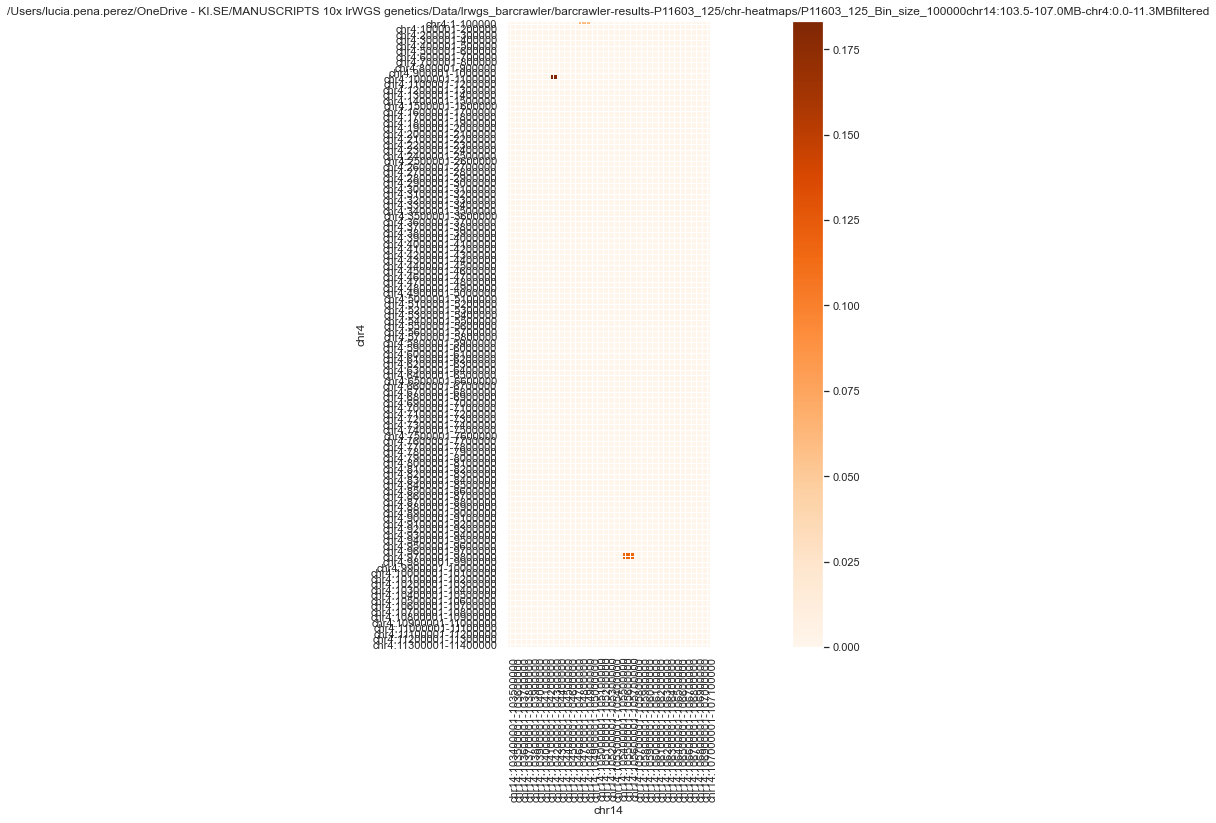

/var/folders/xx/n8fzttqj35db471_9hpyc88m0000gq/T/ipykernel_4673/2980790937.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)


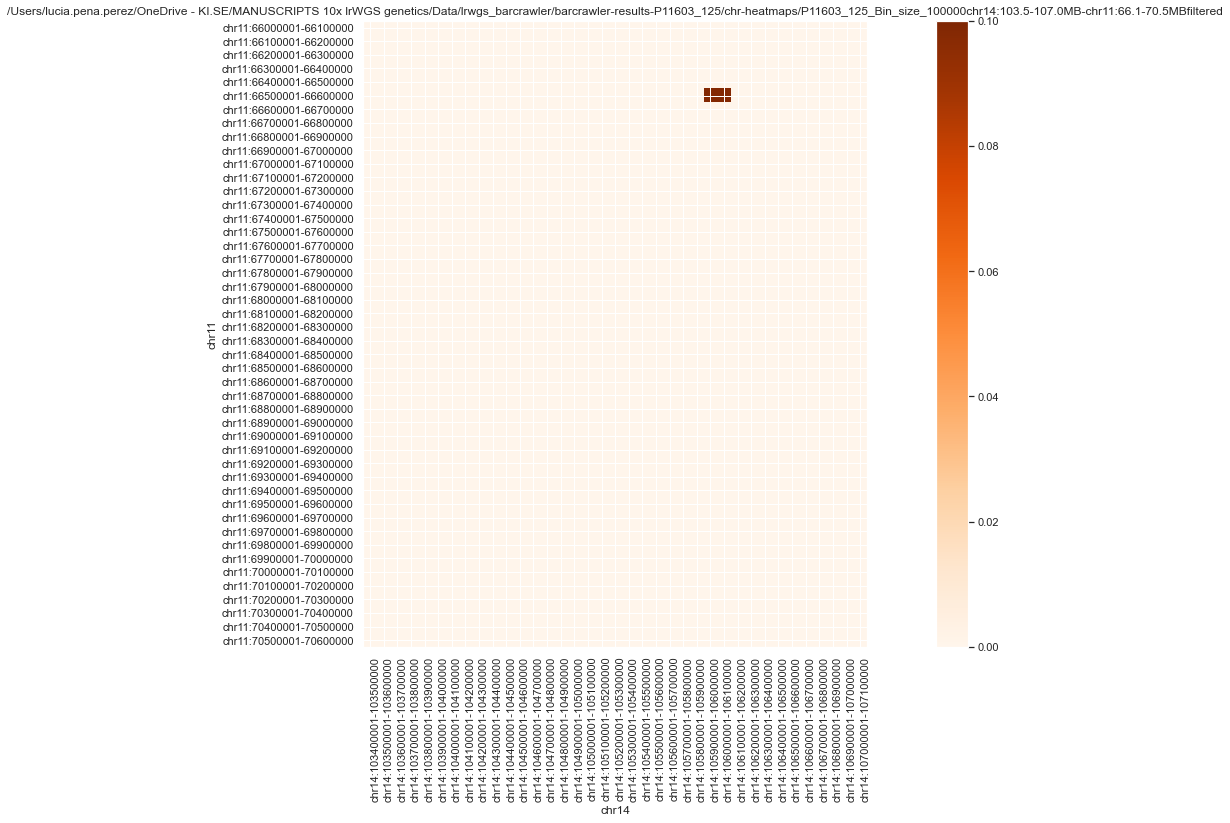

/var/folders/xx/n8fzttqj35db471_9hpyc88m0000gq/T/ipykernel_4673/2980790937.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)


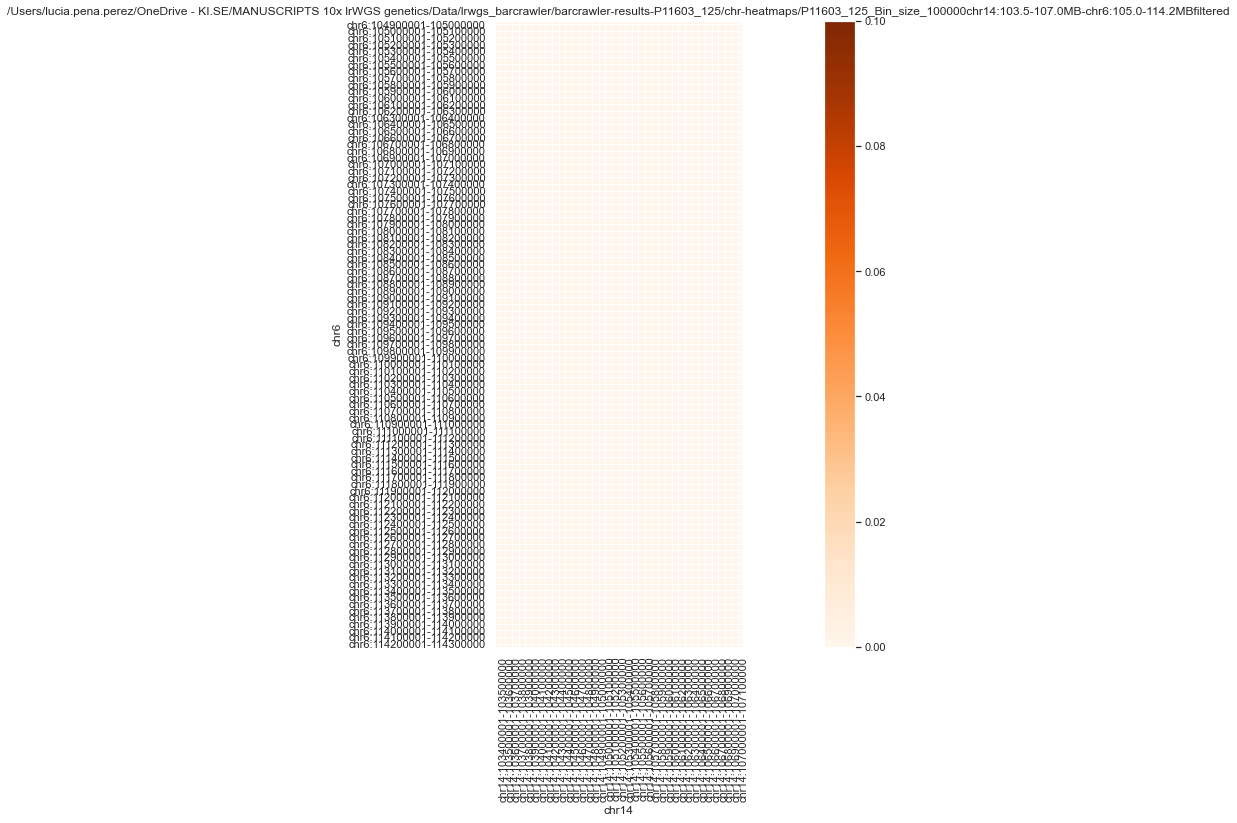

/var/folders/xx/n8fzttqj35db471_9hpyc88m0000gq/T/ipykernel_4673/2980790937.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)


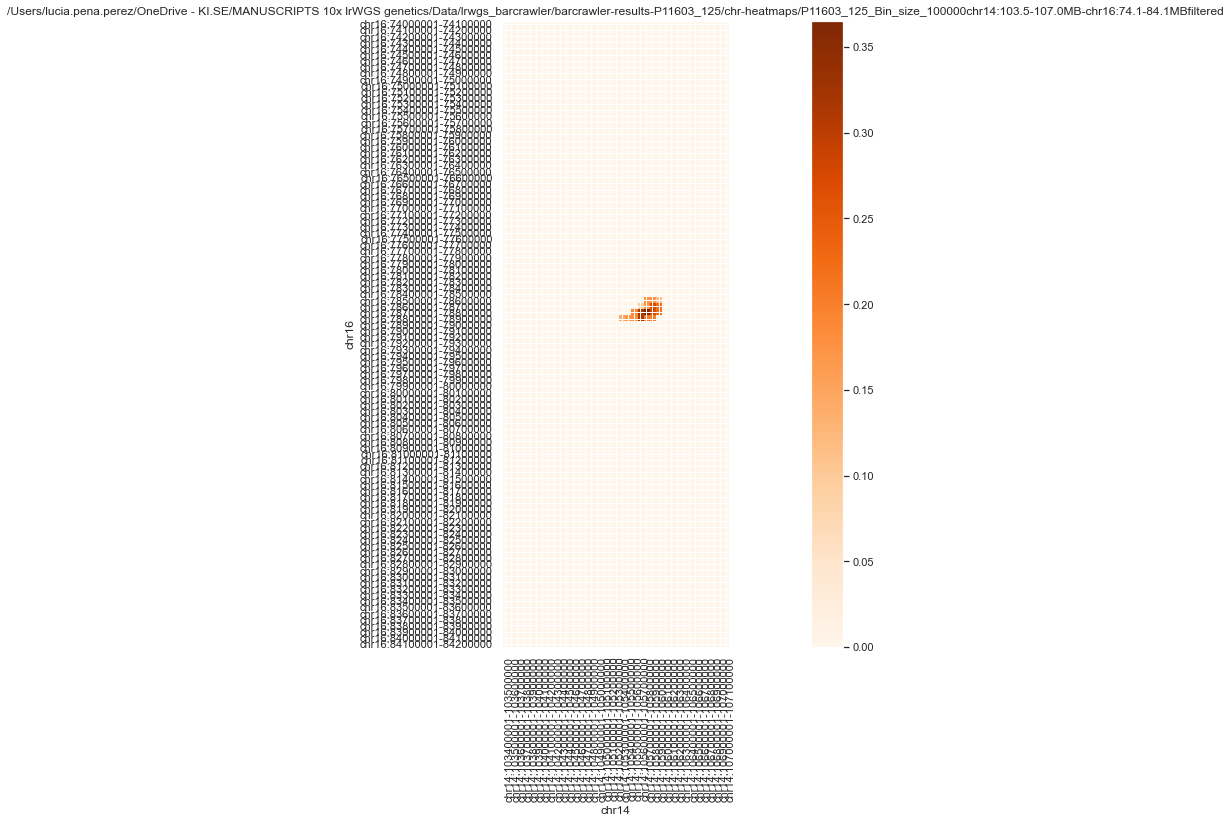

Number of clusters
1


/var/folders/xx/n8fzttqj35db471_9hpyc88m0000gq/T/ipykernel_4673/2980790937.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)


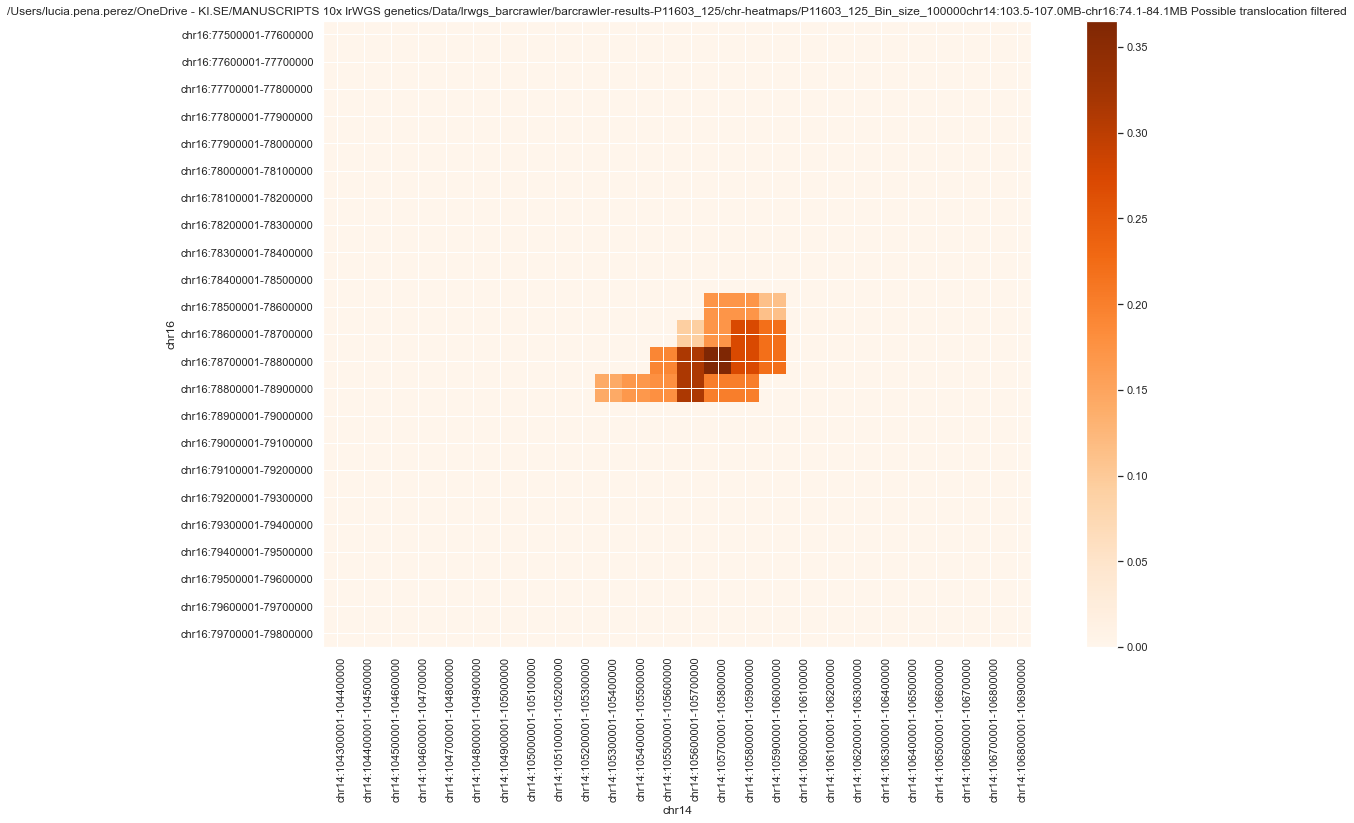

In [4]:
# Running order
if (filter_bins == True):
    for i in range(len(reg2)):
        region2=reg2[i]
        region1=reg1
        chrom=[region1.split(':')[0],region2.split(':')[0]]
        whole_int_chr1=chrom[0]+":"+"0""-"+str(chrom_size.chr_len[chrom_size.chr_name==chrom[0]]).split("    ")[1].split("\n")[0]
        whole_int_chr2=chrom[1]+":"+"0""-"+str(chrom_size.chr_len[chrom_size.chr_name==chrom[1]]).split("    ")[1].split("\n")[0]
        reg1MB=np.round(np.array((region1.split(":")[1].split("-"))).astype(int)/1e6,1)
        reg2MB=np.round(np.array((region2.split(":")[1].split("-"))).astype(int)/1e6,1)
        dfbins_filt=filtering_bins(dfbins,region1=region1,region2=region2, bin_size=bin_size)
        dfbins_filt_chr=filtering_bins(dfbins,region1=whole_int_chr1,region2=whole_int_chr2, bin_size=bin_size)
        df_filt_chr=filtering_bins(df_all,region1=whole_int_chr1,region2=whole_int_chr2, bin_size=0)
        
        # Making Ranges
        sdfgr=pyranges.PyRanges(df_filt_chr)
        dfbinsgr=pyranges.PyRanges(dfbins_filt_chr)
        # Overlaping them
        dfcomb_tot_interm=sdfgr.nearest(dfbinsgr, suffix="_bin")
        dfcomb_tot=pd.DataFrame({"Bin":dfcomb_tot_interm.Bin.map(str),"BX":dfcomb_tot_interm.BX.map(str)})
        
        # Droping duplicates (same bin and same BX)
        dfcomb_tot=dfcomb_tot.drop_duplicates(['BX','Bin'])
        dfcomb_tot['BX'].value_counts().describe()
        
        # Subsetting dataframe to take only the BX in chrom
        int_rowa=dfcomb_tot['Bin'].str.contains(chrom[0]+":")
        int_rowb=dfcomb_tot['Bin'].str.contains(chrom[1]+":")
        
        dfcomb_tota=dfcomb_tot[int_rowa]
        dfcomb_totb=dfcomb_tot[int_rowb]
        
        # Temp dataframe where cols and rows are the bins in chrom
        temp=pd.DataFrame(0,columns=dfbins_filt_chr.Bin[dfbins_filt_chr.Chromosome==chrom[0]],index=dfbins_filt_chr.Bin[dfbins_filt_chr.Chromosome==chrom[1]])
        # Filling in the df by finding all BX in each column and then checking how many are in the other one too
        for column in temp:
            BXs=dfcomb_tota.BX[dfcomb_tota.Bin==column]
            bins=dfcomb_totb.Bin[dfcomb_totb.BX.isin(BXs)].value_counts()
            temp.loc[bins.index,column]=bins.values
        
        rowsum=temp.sum(axis=1)
        colsum=temp.sum(axis=0)
        
        # Filter on interesting bins
        bins_chra=list(dfbins_filt.Bin[dfbins_filt.Bin.str.contains(chrom[0]+":")])
        bins_chrb=list(dfbins_filt.Bin[dfbins_filt.Bin.str.contains(chrom[1]+":")])
        name_image=path+patient+"/chr-heatmaps/"+patient+"_Bin_size_"+str(bin_size)+  chrom[0] +":" + str(reg1MB[0])+"-"+str(reg1MB[1])+"MB"+"-"+chrom[1] +":" + str(reg2MB[0])+"-"+str(reg2MB[1])+"MB"
        final_dataframe=((temp.div((colsum+1), axis=1)+temp.div((rowsum+1), axis=0))/2)
        ima=np.array(final_dataframe)
        ima_med=ndimage.median_filter(ima, 2)
        final_dataframe_filt=pd.DataFrame(ima_med, index=final_dataframe.index,columns=final_dataframe.columns)
        
        # Normalize by row and plot
        # HM_bins(dataframe=temp.div((rowsum+1), axis=0).loc[bins_chrb,bins_chra], name_png=name_image+"rowwise")
        # HM_bins(dataframe=temp.div((colsum+1), axis=1).loc[bins_chrb,bins_chra], name_png=name_image+"colwise")
        # HM_bins(dataframe=final_dataframe.loc[bins_chrb,bins_chra], name_png=name_image+"mean_both")
        HM_bins(dataframe=final_dataframe_filt.loc[bins_chrb,bins_chra], name_png=name_image+"filtered")
        
        # With weight
        rows_ima, cols_ima = np.where(ima_med!=0)
        X=np.column_stack((rows_ima, cols_ima))
        w=ima_med[np.where(ima_med!=0)]
        #rows_ima, cols_ima = np.where(ima_med>=0)
        #X=np.column_stack((rows_ima, cols_ima))
        #w=ima_med[np.where(ima_med>=0)] 
        epsilon = 3
        minimumSamples = 2
        db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X,sample_weight=w)
        labels = db.labels_
        
        # Number of clusters = 1 indicates possible translocations and outputs a figure
        if (len(np.unique(labels))-1) > 0:
            print("Number of clusters") 
            print((len(np.unique(labels))-1))
            
            blop_cols=cols_ima[labels==labels.max()]
            blop_rows=rows_ima[labels==labels.max()]
            #final_dataframe_filt.iloc[(blop_rows.min()-10):(blop_rows.max()+10),(blop_cols.min()-10):(blop_cols.max()+10)]
            HM_bins(dataframe=final_dataframe_filt.iloc[(blop_rows.min()-10):(blop_rows.max()+10),(blop_cols.min()-10):(blop_cols.max()+10)], name_png=name_image+" Possible translocation filtered")